In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

This is not a multi-classification problem per Jan

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import pickle

In [124]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

1.Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [38]:
query1 = '''select title, film_id, c.name as category, rating, release_year, length, 
l.name as language, rental_rate, rental_duration, special_features
from film f
join language l using(language_id)
join film_category fc using(film_id)
join category c using(category_id)
    ;
;
'''
pd.read_sql_query(query1, engine)


,title,film_id,category,rating,release_year,length,language,rental_rate,rental_duration,special_features
0,AMADEUS HOLY,19,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes"
1,AMERICAN CIRCUS,21,Action,R,2006,129,English,4.99,3,"Commentaries,Behind the Scenes"
2,ANTITRUST TOMATOES,29,Action,NC-17,2006,168,English,2.99,5,"Trailers,Commentaries,Deleted Scenes"
3,ARK RIDGEMONT,38,Action,NC-17,2006,68,English,0.99,6,"Trailers,Commentaries,Deleted Scenes,Behind th..."
4,BAREFOOT MANCHURIAN,56,Action,G,2006,129,English,2.99,6,"Trailers,Commentaries"
...,...,...,...,...,...,...,...,...,...,...
995,VALENTINE VANISHING,931,Travel,PG-13,2006,48,English,0.99,7,"Trailers,Behind the Scenes"
996,WINDOW SIDE,977,Travel,R,2006,85,English,2.99,3,"Deleted Scenes,Behind the Scenes"
997,WOLVES DESIRE,981,Travel,NC-17,2006,55,English,0.99,7,Behind the Scenes
998,WORKER TARZAN,988,Travel,R,2006,139,English,2.99,7,"Trailers,Commentaries,Behind the Scenes"


2.Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

In [39]:
query = '''select film_id, (rental_date>'2005-08-01' and rental_date<'2005-09-01') as august_rental
from rental
join inventory using(inventory_id)
'''
pd.read_sql_query(query, engine)

,film_id,august_rental
0,1,0
1,1,1
2,1,1
3,1,0
4,1,0
...,...,...
16040,1000,0
16041,1000,0
16042,1000,0
16043,1000,0


In [125]:
query2 = '''select title, category, rating, release_year, length, language, rental_rate, 
rental_duration, special_features, (rental_date>'2005-08-01' and rental_date<'2005-09-01') as august_rental
from (
    select title, film_id, c.name as category, rating, release_year, length, 
    l.name as language, rental_rate, rental_duration, special_features
    from film f
    join language l using(language_id)
    join film_category fc using(film_id)
    join category c using(category_id) 
    ) t1
left join (
    select film_id, rental_date
    from rental
    join inventory using(inventory_id)
    where rental_date between '2005-01-01' and '2006-01-01'
    ) t2
on t1.film_id = t2.film_id;
'''

pd.read_sql_query(query2, engine)

,title,category,rating,release_year,length,language,rental_rate,rental_duration,special_features,august_rental
0,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",1.0
1,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",1.0
2,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",0.0
3,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",0.0
4,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",0.0
...,...,...,...,...,...,...,...,...,...,...
15899,WORKING MICROCOSMOS,Travel,R,2006,74,English,4.99,4,"Commentaries,Deleted Scenes",0.0
15900,WORKING MICROCOSMOS,Travel,R,2006,74,English,4.99,4,"Commentaries,Deleted Scenes",0.0
15901,WORKING MICROCOSMOS,Travel,R,2006,74,English,4.99,4,"Commentaries,Deleted Scenes",0.0
15902,WORKING MICROCOSMOS,Travel,R,2006,74,English,4.99,4,"Commentaries,Deleted Scenes",0.0


3.Read the data into a Pandas dataframe.

In [126]:
data = pd.read_sql_query(query2, engine)
data.head()

,title,category,rating,release_year,length,language,rental_rate,rental_duration,special_features,august_rental
0,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",1.0
1,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",1.0
2,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",0.0
3,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",0.0
4,AMADEUS HOLY,Action,PG,2006,113,English,0.99,6,"Commentaries,Deleted Scenes,Behind the Scenes",0.0


4.Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [61]:
#data.category.value_counts()
#data.rating.value_counts()
#data.release_year.value_counts()  #all are 2006, drop column
#data.length.value_counts()
#data.language.value_counts()    #all are English, drop column
#data.rental_rate.value_counts()     #change to categorical
#data.rental_duration.value_counts()   #change to categorical
data.special_features.value_counts()   #split special features?

Trailers,Commentaries,Behind the Scenes                   1311
Trailers                                                  1140
Trailers,Commentaries                                     1134
Trailers,Behind the Scenes                                1127
Behind the Scenes                                         1110
Commentaries,Deleted Scenes,Behind the Scenes             1102
Commentaries                                              1090
Commentaries,Behind the Scenes                            1078
Trailers,Deleted Scenes                                   1048
Deleted Scenes,Behind the Scenes                          1039
Deleted Scenes                                            1027
Commentaries,Deleted Scenes                               1014
Trailers,Commentaries,Deleted Scenes,Behind the Scenes     989
Trailers,Commentaries,Deleted Scenes                       920
Trailers,Deleted Scenes,Behind the Scenes                  775
Name: special_features, dtype: int64

In [68]:
data.isnull().sum()

title               0
category            0
rating              0
length              0
rental_rate         0
rental_duration     0
special_features    0
august_rental       0
dtype: int64

In [127]:
#for all NaN values in august_rental column(for films in inventory with no rental history 
#in 2005) I am filling with 0 as they were also not rented in August 2005
data.august_rental = data.august_rental.fillna(0)

In [128]:
data.drop(['title'], axis=1, inplace=True) 

In [129]:
#dropping release_year and language columns as all values are the same
data.drop(['release_year', 'language'], axis=1, inplace=True) 

In [130]:
#changing rental_rate and rental_duration to a categorical value
data['rental_rate'] = data['rental_rate'].astype('object')
data['rental_duration'] = data['rental_duration'].astype('object')

In [131]:
#splitting special_features into categories: trailer, commentaries, behind the scenes, deleted scenes

def make_trailer(x):
    x = data.special_features[i].split(',')
    if 'Trailers' in x:
        return 1

def make_commentaries(x):
    x = data.special_features[i].split(',')
    if 'Commentaries' in x:
        return 1
    
def make_behindts(x):
    x = data.special_features[i].split(',')
    if 'Behind the Scenes' in x:
        return 1

def make_deletedscenes(x):
    x = data.special_features[i].split(',')
    if 'Deleted Scenes' in x:
        return 1

In [132]:
data['trailers'] = list(map(make_trailer, data.special_features))
data['commentaries'] = list(map(make_commentaries, data.special_features))
data['behind_the_scenes'] = list(map(make_behindts, data.special_features))
data['deleted_scenes'] = list(map(make_deletedscenes, data.special_features))

data['trailers'] = data['trailers'].fillna(0)
data['commentaries'] = data['commentaries'].fillna(0)
data['behind_the_scenes'] = data['behind_the_scenes'].fillna(0)
data['deleted_scenes'] = data['deleted_scenes'].fillna(0)

In [133]:
data.drop(['special_features'], axis=1, inplace=True)

In [102]:
data.head()

,title,category,rating,length,rental_rate,rental_duration,august_rental,trailers,commentaries,behind_the_scenes,deleted_scenes
0,AMADEUS HOLY,Action,PG,113,0.99,6,1.0,0,1,1,1
1,AMADEUS HOLY,Action,PG,113,0.99,6,1.0,0,1,1,1
2,AMADEUS HOLY,Action,PG,113,0.99,6,0.0,0,1,1,1
3,AMADEUS HOLY,Action,PG,113,0.99,6,0.0,0,1,1,1
4,AMADEUS HOLY,Action,PG,113,0.99,6,0.0,0,1,1,1


In [90]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
length,15904.0,114.980319,40.112051,46.0,81.0,114.0,148.0,185.0
august_rental,15904.0,0.357520,0.479285,0.0,0.0,0.0,1.0,1.0
commentaries,15904.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
behind_the_scenes,15904.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
deleted_scenes,15904.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [ ]:
#minmaxscale length???

In [ ]:
#encode categories:  category, rating, rental_rate, rental_duration
#get_dummies?

In [99]:
data.dtypes

title                 object
category              object
rating                object
length                 int64
rental_rate           object
rental_duration       object
special_features      object
august_rental        float64
trailers               int64
commentaries           int64
behind_the_scenes      int64
deleted_scenes         int64
dtype: object

In [134]:
cat = data.select_dtypes(include = object)

categorical = pd.get_dummies(cat, 
                             columns=['category', 'rating', 'rental_rate', 'rental_duration'],
                             drop_first=True)
categorical.head()

,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,...,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_rate_2.99,rental_rate_4.99,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [135]:
data.drop(['category', 'rating', 'rental_rate', 'rental_duration'], axis=1, inplace=True)

In [113]:
data.head()

,title,length,august_rental,trailers,commentaries,behind_the_scenes,deleted_scenes
0,AMADEUS HOLY,113,1.0,0,1,1,1
1,AMADEUS HOLY,113,1.0,0,1,1,1
2,AMADEUS HOLY,113,0.0,0,1,1,1
3,AMADEUS HOLY,113,0.0,0,1,1,1
4,AMADEUS HOLY,113,0.0,0,1,1,1


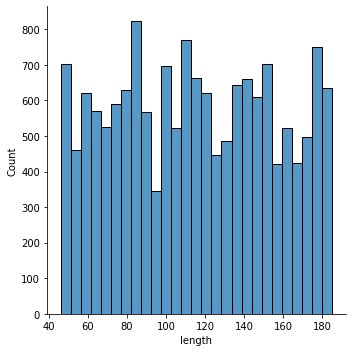

In [108]:
sns.displot(data['length'])
plt.show()

5.Create a logistic regression model to predict this variable from the cleaned data.

In [136]:
#x-y split
x = data.drop(['august_rental'], axis=1)
y = data['august_rental']
X = np.concatenate((x, categorical), axis=1)

In [154]:
# train test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [155]:
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [156]:
predictions = classification.predict(X_test)

6.Evaluate the results.

In [157]:
classification.score(X_test, y_test)
#score .646 with test_size= .2
#score .648 with test_size= .3

0.6475272422464375

In [158]:
print(y_test.value_counts())

0.0    3090
1.0    1682
Name: august_rental, dtype: int64


In [159]:
pd.Series(predictions).value_counts()

0.0    4772
dtype: int64

In [160]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[3090,    0],
       [1682,    0]])

In [ ]:
#The model is not predicting any movies to be rented... not a good model.

In [ ]:
#trying KNN instead of logistic regression

In [161]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform') 
clf.fit(X, y)                                       
predictions_clf = clf.predict(X_test)
clf.score(X_test, y_test)
#score .614 with test_size= .2
#score .622 with test_size= .3

0.6219614417435038

In [162]:
print(y_test.value_counts())

0.0    3090
1.0    1682
Name: august_rental, dtype: int64


In [163]:
pd.Series(predictions).value_counts()

0.0    4772
dtype: int64

In [ ]:
#still predicting no rentals...